In [26]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import itertools
from IPython.display import clear_output, Image
import time
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, silhouette_score 
from sklearn.grid_search import GridSearchCV
from operator import itemgetter
import math
import cPickle
import warnings
import os
from sklearn.cluster import MiniBatchKMeans, KMeans
import seaborn.apionly as sns
import json, urllib
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline

%pylab inline

# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

tableau10 = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
for i in range(len(tableau10)):  
    r, g, b = tableau10[i]  
    tableau10[i] = (r / 255., g / 255., b / 255.)
    
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# plt.rcParams['font.serif'] = 'Arial'
# plt.rcParams['font.family'] = "sans-serif"
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.prop_cycle'] = cycler('color',tableau20)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14

%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# Define colormap
cdict1 = {'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
                (1.0, 0.9607843137254902, 0.9607843137254902)),
        'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
                  (1.0, 0.15294117647058825, 0.15294117647058825)),
        'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
                 (1.0, 0.3411764705882353, 0.3411764705882353)),
        'alpha': ((0.0, 1, 1),
                  (0.5, 0.3, 0.3),
                  (1.0, 1, 1))}

red_blue = LinearSegmentedColormap('RedBlue', cdict1)

essCol=[]
for i in np.arange(0,1,0.01):
    essCol.append(red_blue(i))
    
bepCol=[]
for i in np.arange(0.15, 1, 0.25):
    bepCol.append(red_blue(i))

Populating the interactive namespace from numpy and matplotlib


## Data pre-processing
Here I pre-process the dataset prior to any modeling. I flag extreme values in features, remove outliers and generate new useful features.

In [2]:
def flagging(df, series):
    
    """"Removes values outside 3 std from the sample mean in a given series."""
    
    mean = np.nanmean(df[str(series)])
    std = np.nanstd(df[str(series)])
    s = [0 if ((x>mean-3*std) and (x<mean+3*std)) else 1 for x in df[str(series)]]
    return s

def preProcess(df):
    
    """"Cleans the data and creates additional features."""
    
    # Select residential buildings for analysis
    typology = 'Multifamily Housing'
    df = df[df.BldgType == typology]
    
    # Flag outliers
    df['BuiltFAR_flag'] = flagging(df, 'BuiltFAR')
    df['Num_Bedroom_flag'] = flagging(df, 'Num_Bedroom')
    df['Num_Units_flag'] = flagging(df, 'Num_Units')
    df['Bedrooms_dens_flag'] = flagging(df, 'Bedrooms_dens')
    df['Units_dens_flag'] = flagging(df, 'Units_dens')
    df['NumFloors_flag'] = [1 if x == 0 else 0 for x in df['NumFloors']]
    
    # Remove flagged buildings
    df = df[(df.dup_ID==0) & (df.parent==0) 
        & (df.missing_bbl==0) & (df.multiple_bbl==0) & (df.dup_bbl_bin==0) 
        & (df['missing_EUI']==0) & (df['EUI_0']==0) & (df['EUI_2std']==0)
           & (df['missing_GFA']==0) & (df['GFA_0']==0) & (df['GFA_2std']==0) 
           & (df['BuiltFAR_flag']==0) & (df['Bedrooms_dens_flag']==0) & (df['Units_dens_flag']==0) 
            & (df['NumFloors_flag']==0)] 
    
    # Create a couple of more features
    df['prewar'] = (df['Year'] < 1940).astype(int)
    df['elec_100pct'] = (df['Electricity_%'] > 99).astype(int)
    df['Bedrooms_dens'] = df['Bedrooms_dens']*1000
    df['Units_dens'] = df['Units_dens']*1000
    
    
    X = df[['NumFloors', 'BuiltFAR', 'BldgValue_sqrft', 'GFA', 'WN_Source_EUI',
        'non_main_type_%', 'Attached', 'Corner', 'Inside', 'Altered',
        'elec_100pct','Fuel_5_6_Usage', 'Heating_100%', 'Cooling_80%', 'Steam_primary',
        'Cooling_0%', 'Num_Bedroom', 'Num_Units', 'Units_dens', 'Bedrooms_dens', 'prewar', 'Electricity_primary', 
         'Year', 'Occupancy', 'Is_Subsidized', 'Laundry_in_Unit']]

    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.dropna()

    y = X.WN_Source_EUI 
    X.drop(['WN_Source_EUI'], axis=1, inplace=True)

    X = X.astype(float)
    
    # create train/validation split
    Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=14)
    dtrain = xgb.DMatrix(Xt.as_matrix(), label=yt.as_matrix())
    dtest = xgb.DMatrix(Xv.as_matrix(), label=yv.as_matrix())
    
    return df, dtrain, dtest, X, y, Xt, Xv, yt, yv

In [3]:
# Load data
print 'Importing data...'
df = pd.read_csv(r'..\data\2016_modelling.csv')
print 'Data loaded'

typology = 'Multifamily Housing'
df = df[df.BldgType == typology]
print 'Examples in data:', len(df)

df, dtrain, dtest, X, y, Xt, Xv, yt, yv = preProcess(df)

Importing data...
Data loaded
Examples in data: 9611


## Model selection
I run a grid-search CV to find the optimal parameters for the XGBoost algorithm.

In [ ]:
# Initialize params
params = {'max_depth':6,
    'min_child_weight': 1,
    'learning_rate':.3,
    'subsample':1,
    'reg_alpha':0,
    'colsample_bytree':1,
    'colsample_bylevel':1}


min_rmse = float("Inf")
best_params = None

for learning_rate in [.1, .05, .01]:
    for subsample in [.5, .75, 1]:
        for max_depth in range(6,12):
            for min_child_weight in [1, 5, 10]:
                for reg_alpha in [0.1, 1, 100, 1000]:
                    for colsample_bytree in [.5, .75, 1]:
                        for colsample_bylevel in [.5, .75, 1]:
                        
                            clear_output()
                            print("CV with learning_rate={}".format(learning_rate))
                            print("CV with subsample={}".format(subsample))
                            print("CV with max_depth={}".format(max_depth))
                            print("CV with min_child_weight={}".format(min_child_weight))
                            print("CV with reg_alpha={}".format(reg_alpha))

                            # We update our parameters
                            params['learning_rate'] = learning_rate
                            params['subsample'] = subsample
                            params['max_depth'] = max_depth
                            params['min_child_weight'] = min_child_weight
                            params['reg_alpha'] = reg_alpha
                            params['colsample_bytree'] = colsample_bytree
                            params['colsample_bylevel'] = colsample_bylevel

                            # Run and time CV
                            %time cv_results = xgb.cv(params,dtrain,num_boost_round=1000,seed=25,nfold=5,metrics=['rmse'], early_stopping_rounds=20)

                            # Update best score
                            mean_rmse = cv_results['test-rmse-mean'].min()
                            boost_rounds = cv_results['test-rmse-mean'].idxmin()
                            print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
                            if mean_rmse < min_rmse:
                                min_rmse = mean_rmse

                                best_params = {'learning_rate': learning_rate, 'subsample':subsample, 'max_depth':max_depth, 
                                               'min_child_weight':min_child_weight, 'reg_alpha': reg_alpha,
                                              'colsample_bytree': colsample_bytree, 'colsample_bylevel': colsample_bylevel}
                                best_trees = boost_rounds

print('=='*60)
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

In [8]:
best_params = cPickle.load(open('../data/xgb_params.pkl'))
best_trees = cPickle.load(open('../data/xgb_ntrees.pkl'))

best_params['random_state'] = 25
best_params['n_estimators'] = best_trees

In [9]:
print 'Best model params:', best_params
print '=='*50
print 'Best number of trees:', best_trees

Best model params: {'reg_alpha': 100, 'colsample_bytree': 0.75, 'colsample_bylevel': 0.75, 'learning_rate': 0.01, 'min_child_weight': 5, 'n_estimators': 677, 'subsample': 0.75, 'random_state': 25, 'max_depth': 8}
Best number of trees: 677


## Jackknife predictions
To avoid any bias in the EUI estimates, for each example in the dataset I leave the example out and train the model on the remaining set. Then I assess the goodness of fit in this particular example (which can be considered as test set).

In [18]:
feats = X

# Jackknife predictions
newFeats = feats.reset_index(drop=True)
newY = y.reset_index(drop=True)

tmpModel = xgb.XGBRegressor(**best_params)

jacknifePred = []

for i in newFeats.index.values:
    
    tmpFeats = newFeats.drop(i).values
    tmpY = newY.drop(i)
    
    testFeats = newFeats.iloc[i]
    testY = newY.iloc[i]
    
    tmpModel.fit(tmpFeats, tmpY)
    
    clear_output()
    print i,":", tmpModel.score(tmpFeats, tmpY)
    
    y_predict = tmpModel.predict(testFeats)[0]
    
    jacknifePred.append(y_predict)
    
out = open('../data/jackknifePredictions.pkl', 'w')
cPickle.dump(jacknifePred, out)
out.close()

7486 : 0.6101128220874311


In [10]:
jacknifePred = cPickle.load(open('../data/jackknifePredictions.pkl'))

In [11]:
print 'Jackknife prediction R2:', round(r2_score(y, jacknifePred),3)

Jackknife prediction R2: 0.306


## Reproduce EnergyStar model for NYC
Next I reproduce the output of EnergyStar model for NYC residential buildings, to be able to compare with the GREEN grades in later steps.

In [12]:
def ESS_EUIprediction():
    """Predicts source EUI for NYC residential buildings, based on the EnergyStar model specifications."""
    
    dfESS = pd.read_csv(r'..\data\2016_modelling.csv')

    typology = 'Multifamily Housing'
    dfESS = dfESS[dfESS.BldgType == typology]

    # Apply constraints according to Portfolio Manager
    dfESS = dfESS[dfESS['Source_EUI']<300]
    dfESS = dfESS[dfESS['Multifamily Housing - Total Number of Residential Living Units']>20]
    dfESS = dfESS[dfESS['Multifamily Housing - Gross Floor Area (ft_2)']<2000000]
    dfESS = dfESS[dfESS['Multifamily Housing - Total Number of Residential Living Units Density (Number per 1,000 ft_2)']<2.75]
    dfESS = dfESS[(dfESS['Multifamily Housing - Number of Bedrooms Density (Number per 1,000 ft_2)']<3.5)&
           (dfESS['Multifamily Housing - Number of Bedrooms Density (Number per 1,000 ft_2)']>0.5)]

    dfESS.dropna(subset=['Source_EUI'], inplace=True)

    dfESS['low_rise'] = dfESS['NumFloors'].map(lambda x: 1 if x < 5 else 0)
    dfESS['bedrooms_per_unit'] = dfESS['Multifamily Housing - Number of Bedrooms']/dfESS['Multifamily Housing - Total Number of Residential Living Units']

    data_ess = dfESS[['low_rise', 'Multifamily Housing - Total Number of Residential Living Units Density (Number per 1,000 ft_2)',
               'bedrooms_per_unit', 'Source_EUI', 'WN_Source_EUI', 'ESS']]

    # Get HDD and CDD from portfolio mananger for year 2016
    data_ess['HDD'] = 3959
    data_ess['CDD'] = 1617
    data_ess.columns = ['Low Rise', 'Unit Density', 'Bedrooms per Unit', 'Source EUI', 'WN_Source_EUI', 'ESS', 'HDD', 'CDD']
    
    def ESS_function(row):
        return 140.8 + 52.57*(row['Unit Density']-1.215) + 24.45*(row['Bedrooms per Unit']-1.238) - 18.76*row['Low Rise'] + 0.009617*(row['HDD']-4233) + 0.01617*(row['CDD']-1364)

    data_ess['EUI_pred'] = data_ess.apply(ESS_function, axis=1)
    data_ess.dropna(inplace=True)

    return data_ess['Source EUI'].values, data_ess['EUI_pred'].values

In [13]:
essEUI, essEUIpred = ESS_EUIprediction()

C:\Users\sp4356\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sp4356\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sp4356\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

## Assess XGBoost model performance

In [16]:
model = xgb.XGBRegressor(**best_params)
model.fit(feats, y)

xgbFit = model.predict(feats)
xgbErr = y - xgbFit

print "XGB model fit R2:", r2_score(y, xgbFit)
print 'Jackknife predictions R2:', r2_score(y, jacknifePred)

XGB model fit R2: 0.6064015668901258
Jackknife predictions R2: 0.30560176096916525


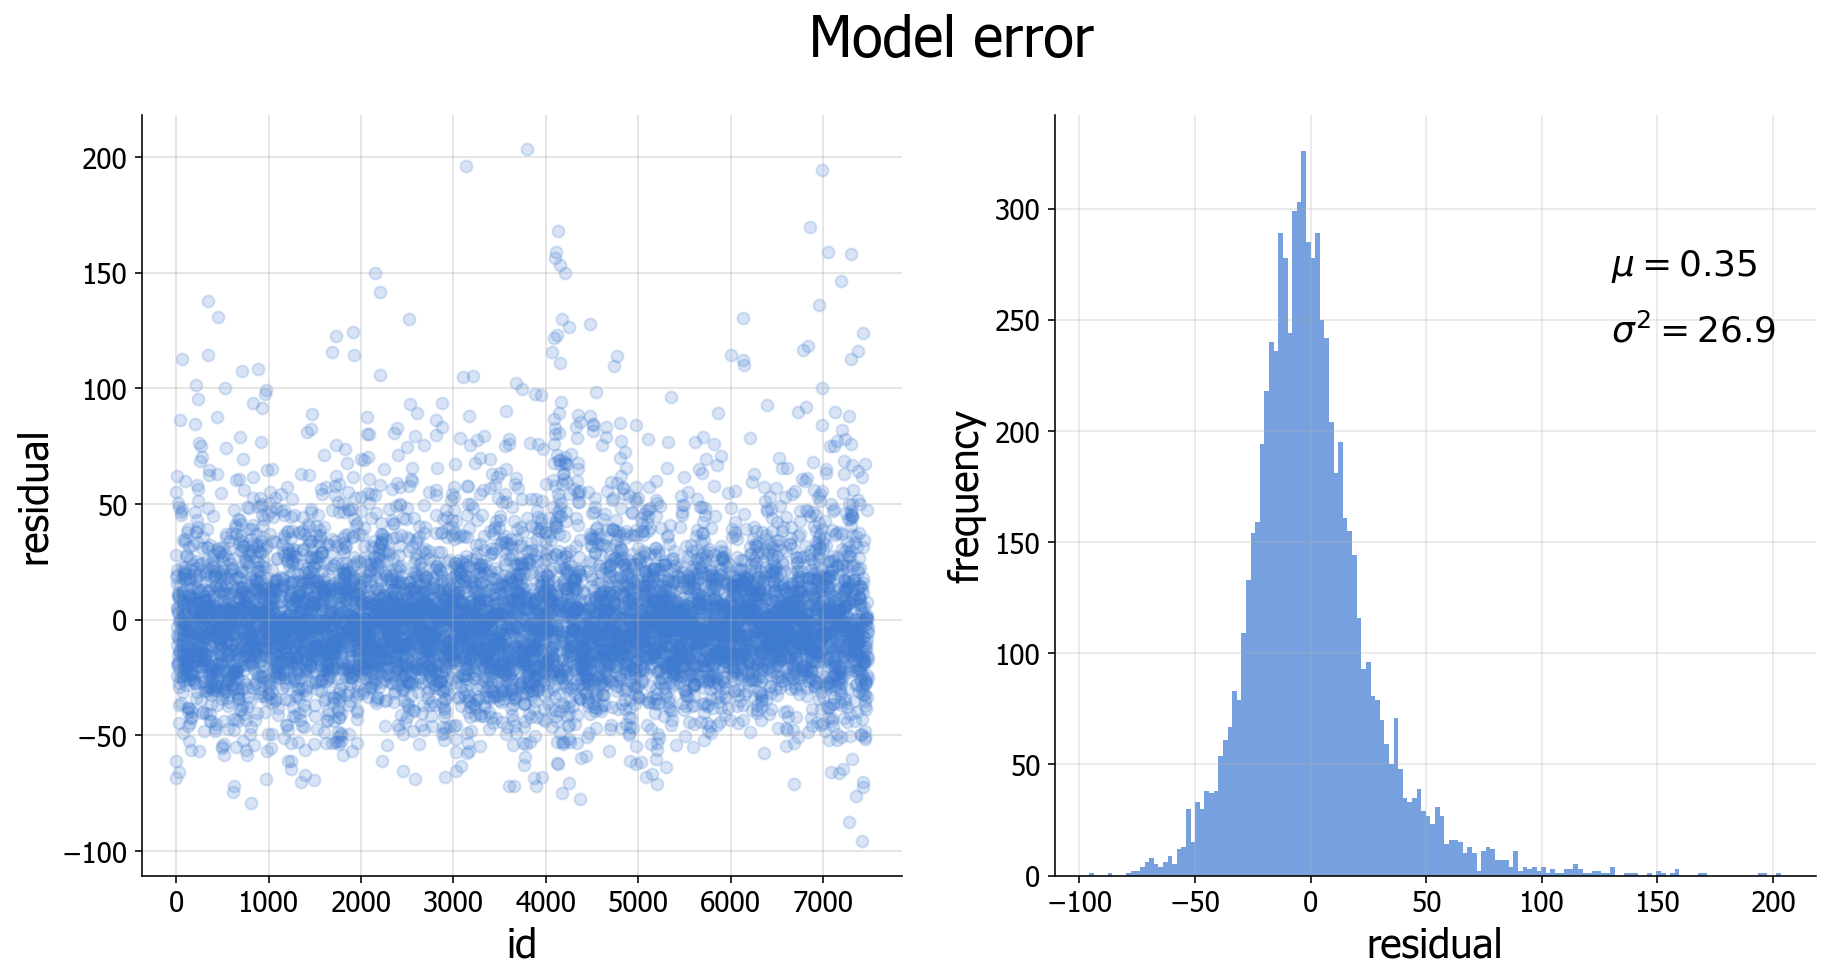

In [17]:
xgbErr = y - xgbFit

plt.figure(figsize=(15,7))
plt.suptitle('Model error', size=28)
plt.grid(alpha=0.4)
plt.subplot(121)
plt.scatter(range(0,len(xgbErr)), xgbErr, color=bepCol[0], alpha=.2)
plt.xlabel('id', size=20)
plt.ylabel('residual', size=20)
plt.grid(alpha=0.4)
plt.subplot(122)
plt.hist(xgbErr, bins=150, color=bepCol[0], alpha=.7)
plt.xlabel('residual', size=20)
plt.ylabel('frequency', size=20)
plt.text(130, 270, '$\mu = %.2f$'%xgbErr.mean(), size=18)
plt.text(130, 240, '$\sigma^{2} = %.1f$'%xgbErr.std(), size=18)
plt.grid(True, alpha=0.3)
plt.show()

#### The error term appears to be normal-like distributed around zero, with stationary variance. We observe no evidence of heteroskedasticity or bias in the model errors.

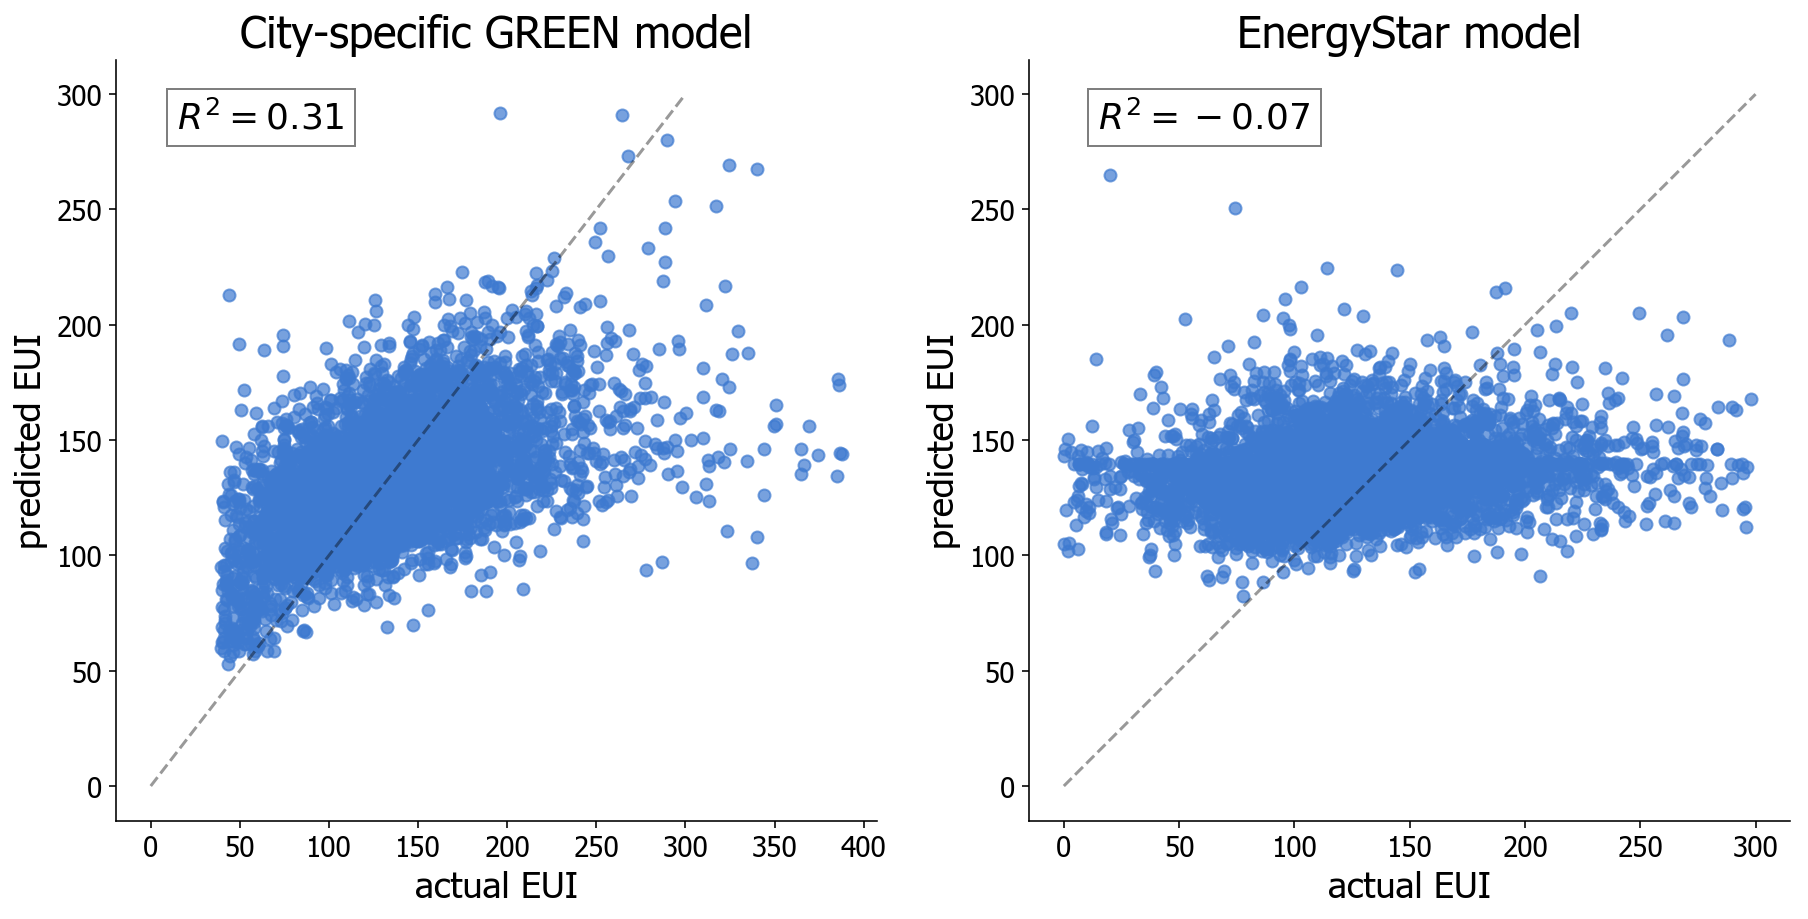

In [18]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.scatter(y, jacknifePred, color=bepCol[0], alpha=.7)
plt.plot(np.linspace(0,300,10), np.linspace(0,300,10), ls='--', color='black', alpha=0.4)
plt.ylabel('predicted EUI')
plt.xlabel('actual EUI')
plt.title('City-specific GREEN model')
plt.text(15,285, '$R^{2} = %.2f$' % r2_score(y, jacknifePred), size=18, 
         bbox=dict(facecolor='none', edgecolor='black', alpha=0.5, pad=5.0))
plt.subplot(122)
plt.scatter(essEUI, essEUIpred, color=bepCol[0], alpha=.7)
plt.plot(np.linspace(0,300,10), np.linspace(0,300,10), ls='--', color='black', alpha=0.4)
plt.ylabel('predicted EUI')
plt.xlabel('actual EUI')
plt.title('EnergyStar model')
plt.text(15,285, '$R^{2} = %.2f$' % r2_score(essEUI, essEUIpred), size=18, 
         bbox=dict(facecolor='none', edgecolor='black', alpha=0.5, pad=5.0))
plt.show()

#### EnergyStar model is not capable of explaining any of the variance in EUI for the city-specific dataset under study. On the other hand, our GREEN grading model explains more than 30% of the variability.

## Feature importance

In [19]:
# print the JS visualization code to the notebook
shap.initjs()

In [69]:
fullsample = xgb.DMatrix(feats, label=y)
model = xgb.train(best_params, fullsample, best_trees, verbose_eval=25)

shap_values = shap.TreeExplainer(model).shap_values(feats)

out = open('../data/shap_values.pkl', 'w')
cPickle.dump(shap_values, out)
out.close()

In [20]:
shap_values = cPickle.load(open('../data/shap_values.pkl'))

C:\Users\sp4356\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\axes\_base.py:1298: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
C:\Users\sp4356\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\axes\_base.py:1303: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


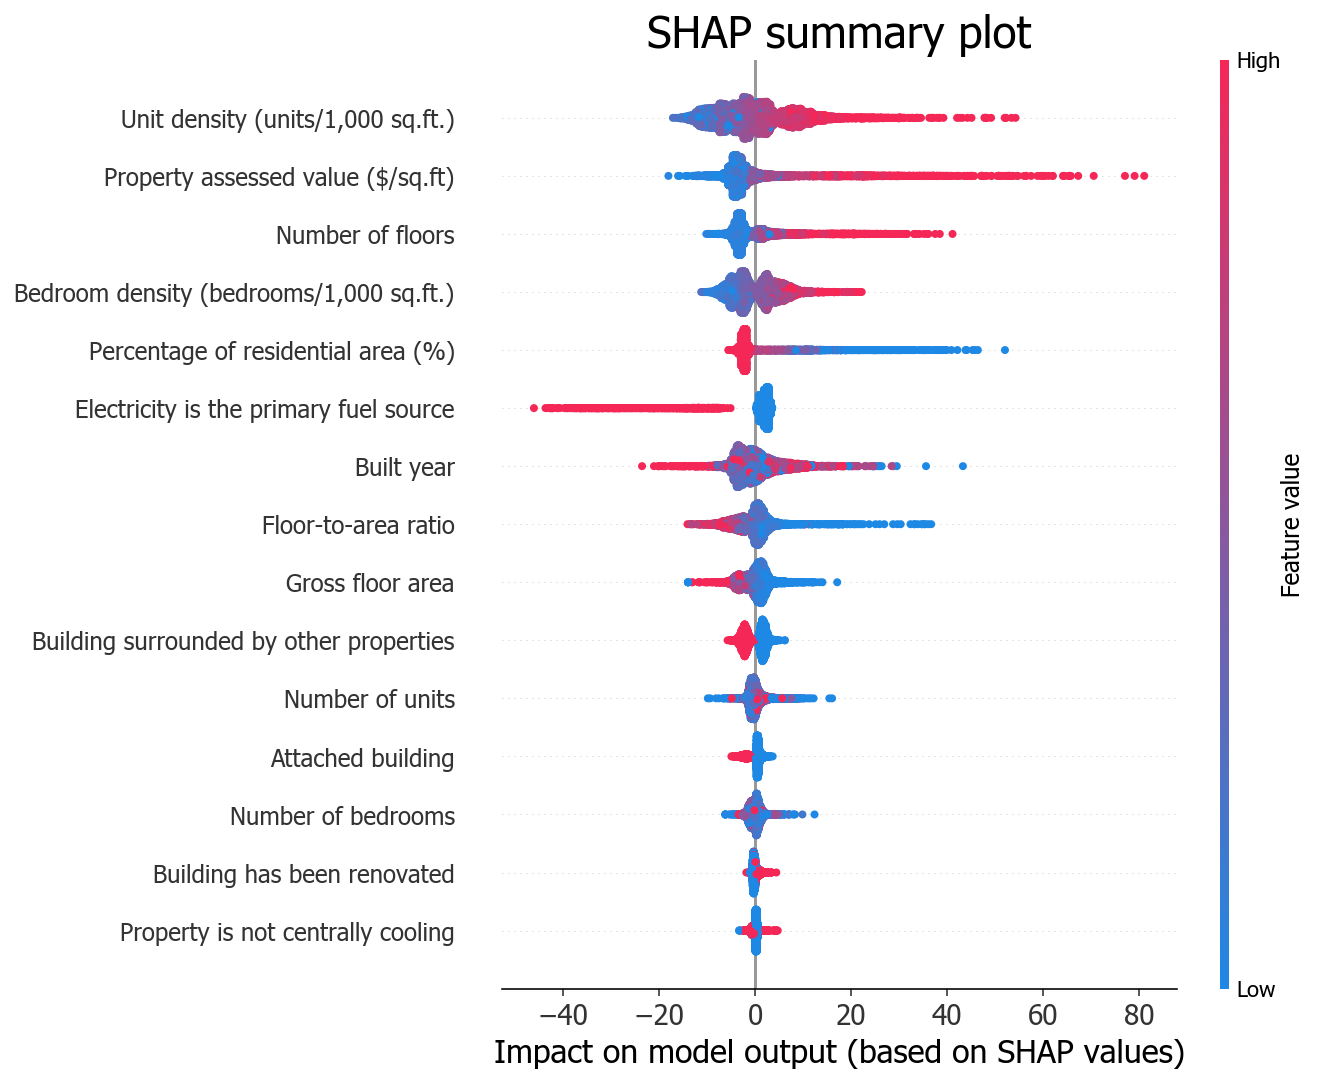

In [22]:
featNames = ['Unit density (units/1,000 sq.ft.)', 'Property assessed value ($/sq.ft)',
             'Number of floors', 'Bedroom density (bedrooms/1,000 sq.ft.)','Percentage of residential area (%)',
             'Electricity is the primary fuel source', 'Built year', 'Floor-to-area ratio', 'Gross floor area',
             'Building surrounded by other properties', 'Number of units', 'Attached building', 'Number of bedrooms',
             'Building has been renovated', 'Property is not centrally cooling']

plt.figure(figsize=(9,6))
shap.summary_plot(shap_values, feats, title='SHAP values', max_display=15, auto_size_plot=True, show=False)
plt.xticks(size=14)
plt.yticks(np.arange(len(featNames)), featNames[::-1], size=12)
plt.xlabel('Impact on model output (based on SHAP values)',size=16)
plt.title('SHAP summary plot')
plt.show()

#### X-axis values correspond to each feature's impact on the model output. Y-axis is sorted based on feature global impact on the model output and color-coded according to the feature value.  

#### For example, Unit Density is the most important feature in the model, with higher densities (red color) yielding higher EUI values. 

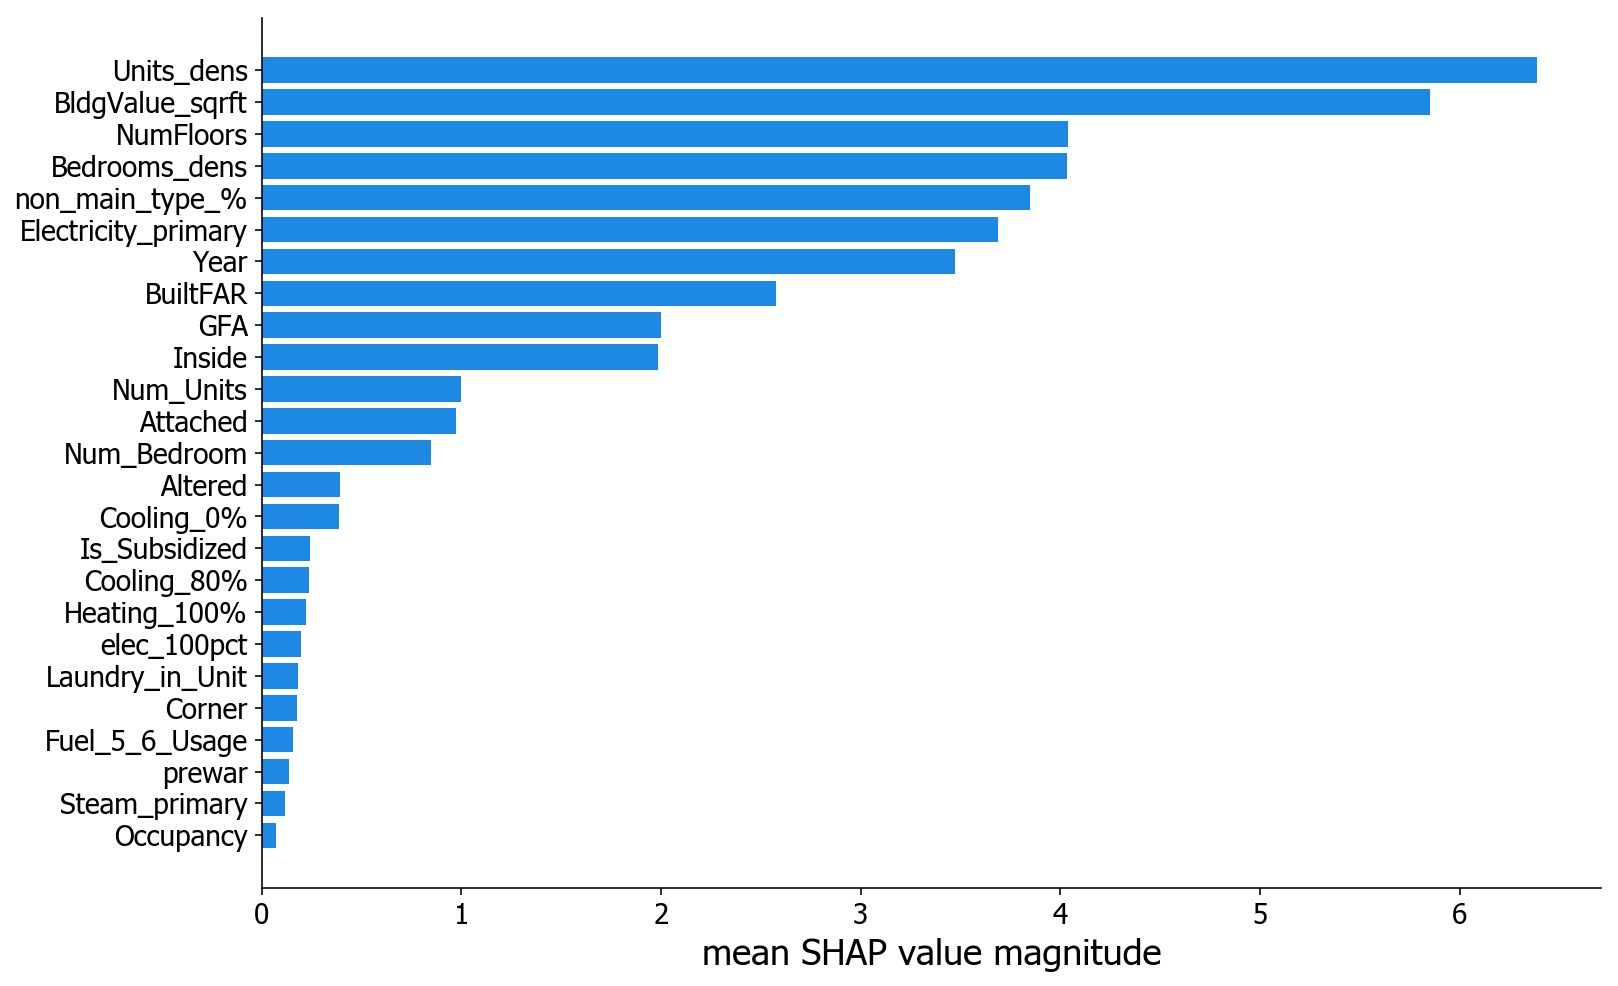

In [24]:
global_shap_vals = np.abs(shap_values).mean(0)[:-1]
inds = np.argsort(global_shap_vals)
y_pos = np.arange(feats.shape[1])
plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
plt.yticks(y_pos, feats.columns[inds])
plt.xlabel("mean SHAP value magnitude")
plt.show()

## GREEN score calculation
I compute the energy performance ratio, defined as: $actual_{EUI}/predicted_{EUI}$.
Following I use KMeans clustering to cluster the energy performance ratios into four classes (A-D) and assign each building with its corresponding GREEN grade.

In [25]:
score = df.WN_Source_EUI/jacknifePred
score.describe()

count    7487.000000
mean        1.001772
std         0.271806
min         0.206555
25%         0.841278
50%         0.973746
75%         1.119021
max         3.483950
Name: WN_Source_EUI, dtype: float64

### Select number of clusters

In [47]:
numOfClusters = 4 # to match the 4-class grading scheme NYC is proposing

In [48]:
errcl = pd.DataFrame()
errcl['er1'] = score
errcl['er2'] = score

clus = KMeans(n_clusters=numOfClusters, random_state=14).fit(errcl)

dfEr = pd.DataFrame()
dfEr['error'] = score
dfEr['label'] = clus.labels_

centroids = clus.cluster_centers_[:,0]
print "Cluster centroids: ", centroids

clus.labels_

Cluster centroids:  [0.97667846 1.25951666 1.85464541 0.71416652]


array([1, 1, 3, ..., 0, 3, 0])

In [60]:
print 'Cluster centroids:', centroids
print '--'*50

bep = dfEr.groupby('label').count()
bep.reset_index(inplace=True)
bep.rename(columns={'error':'counts'}, inplace=True)

bep['clusCenter'] = centroids
bep = bep.sort_values('clusCenter', ascending=True) 
bep['grade'] = ['A', 'B', 'C', 'D']

print '\nClustering descriptive statistics: \n\n', bep
print '--'*50

dictionary = dict(zip(bep['label'].values, bep['grade'].values))
dfEr['grade'] = dfEr['label'].map(dictionary)
print '\nSample buildings: \n\n', dfEr.head(10)

df.BEP_Score = dfEr.grade

Cluster centroids: [0.97667846 1.25951666 1.85464541 0.71416652]
----------------------------------------------------------------------------------------------------

Clustering descriptive statistics: 

   label  counts grade  clusCenter
3      3    1919     A    0.714167
0      0    3684     B    0.976678
1      1    1620     C    1.259517
2      2     264     D    1.854645
----------------------------------------------------------------------------------------------------

Sample buildings: 

       error  label grade
3   1.237554      1     C
4   1.136883      1     C
9   0.355756      3     A
24  1.568900      2     D
28  0.492197      3     A
35  1.669317      2     D
36  0.797213      3     A
37  0.845909      0     B
38  0.985550      0     B
39  1.050722      0     B


In [61]:
# Create bins to calculate ESS based on 10-degree threshholds
bins = np.arange(0,101,1)
df['ESS_grades_10scale'] = pd.cut(df['ESS'], bins)
df['ESS_grades_10scale'] = df['ESS_grades_10scale'].astype(str)

# Similar to what NYC is proposing
bins = np.array([0, 19, 49, 89, 100])
df['ESS_grades_4scale'] = pd.cut(df['ESS'], bins)
df['ESS_grades_4scale'] = df['ESS_grades_4scale'].astype(str)
dropedESS = df[df['ESS_grades_4scale']!='nan']

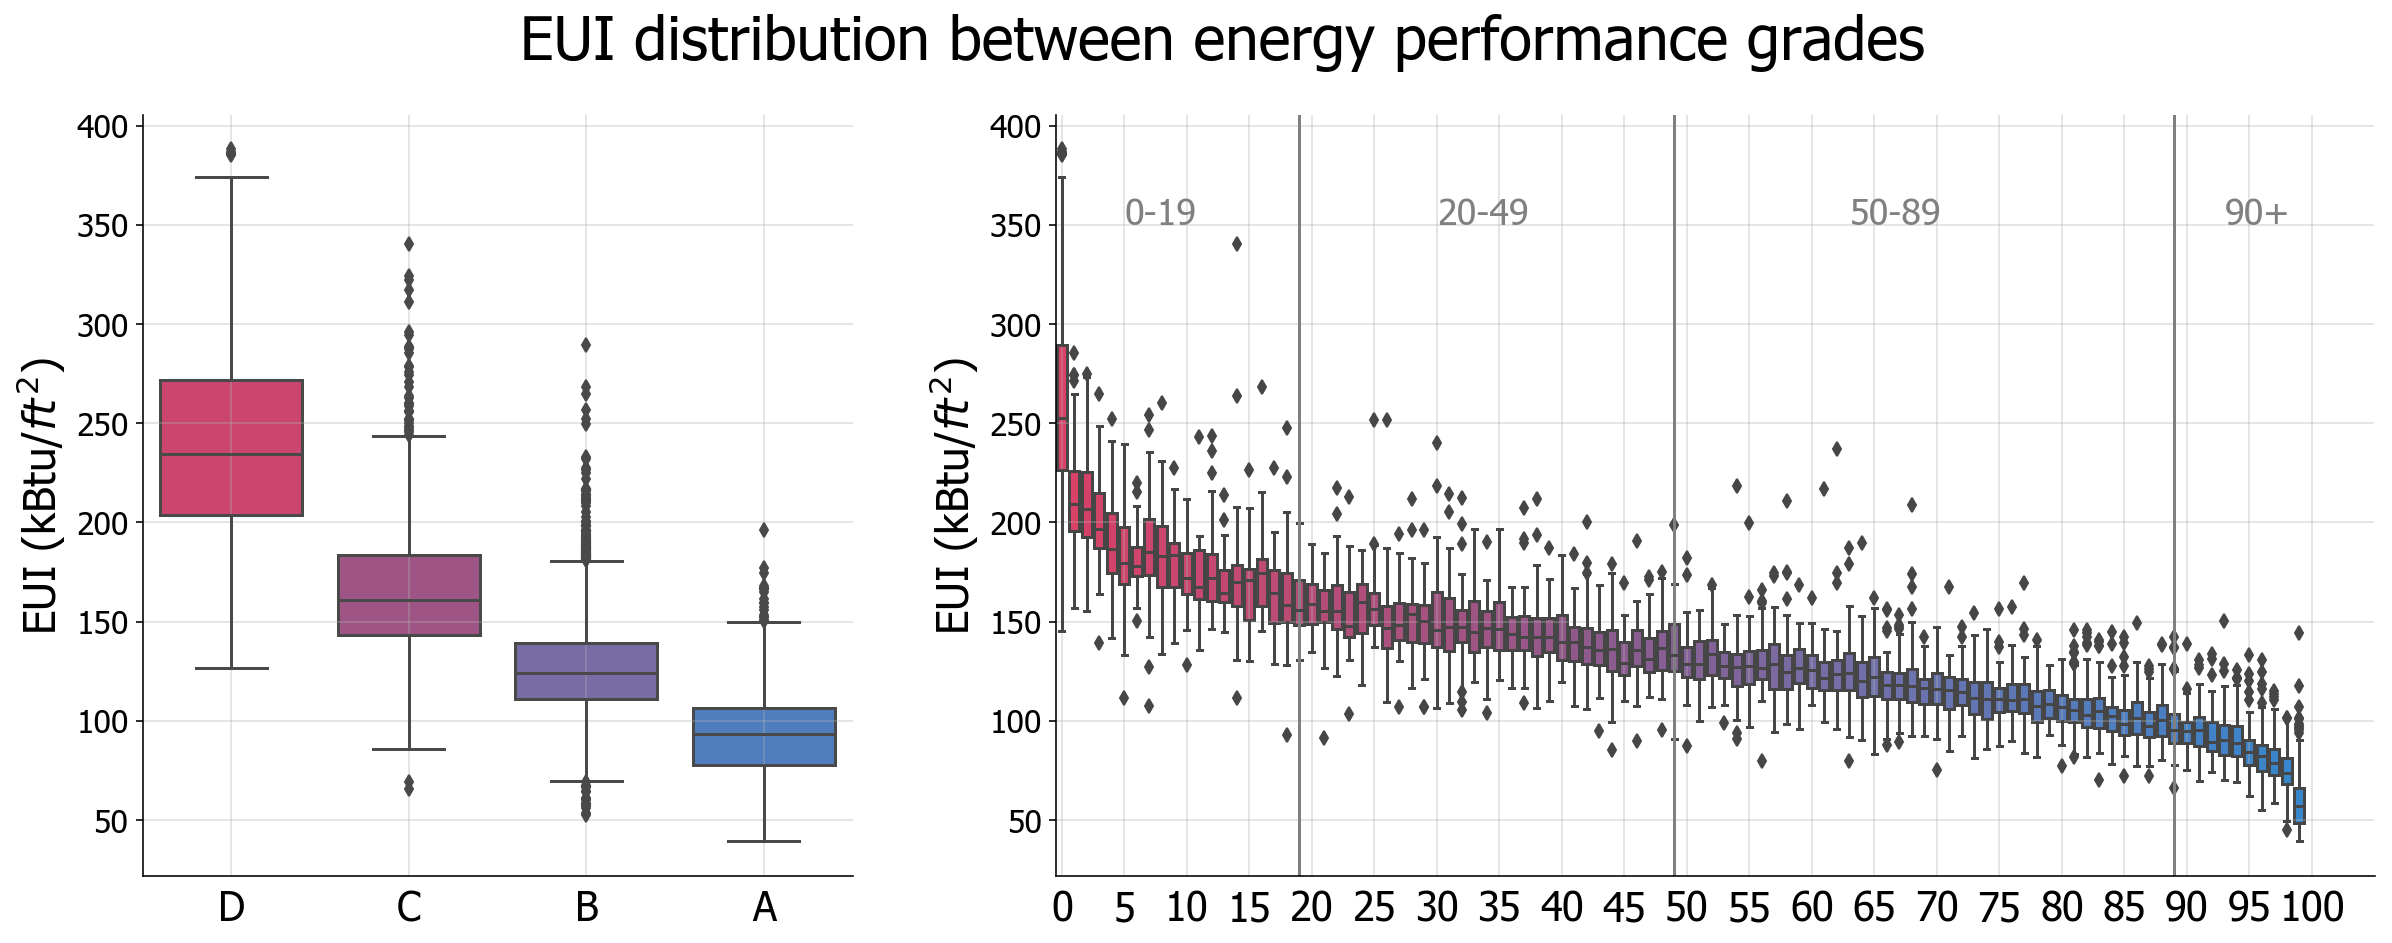

In [63]:
plt.figure(figsize=(20,7))
plt.suptitle('EUI distribution between energy performance grades', size=30)
gs = gridspec.GridSpec(1, 2, width_ratios=[1.4, 2.6]) 
plt.subplot(gs[1])
sns.boxplot(x="ESS", y="WN_Source_EUI", data=df, palette=essCol[::-1])
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.xticks(range(0,110,5), np.arange(0,101,5), size=20, rotation=0)
plt.axvline(x=19, color='grey')
plt.axvline(x=49, color='grey')
plt.axvline(x=89, color='grey')
plt.text(5, 350, '0-19', color='grey', size=18)
plt.text(30, 350, '20-49', color='grey', size=18)
plt.text(63, 350, '50-89', color='grey', size=18)
plt.text(93, 350, '90+', color='grey', size=18)
plt.xlabel('')
plt.grid(alpha=0.4)
plt.ylabel('EUI (kBtu/$ft^{2}$)', size=22)
plt.yticks(size=16)
plt.subplot(gs[0])
sns.boxplot(x="BEP_Score", y="WN_Source_EUI", data=df, order=['D', 'C', 'B', 'A'], palette=bepCol[::-1])
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.grid(alpha=0.4)
plt.xlabel('')
plt.ylabel('EUI (kBtu/$ft^{2}$)', size=22)
plt.yticks(size=16)
plt.xticks(range(0,4), ['D', 'C', 'B', 'A'], size=20)
plt.show()

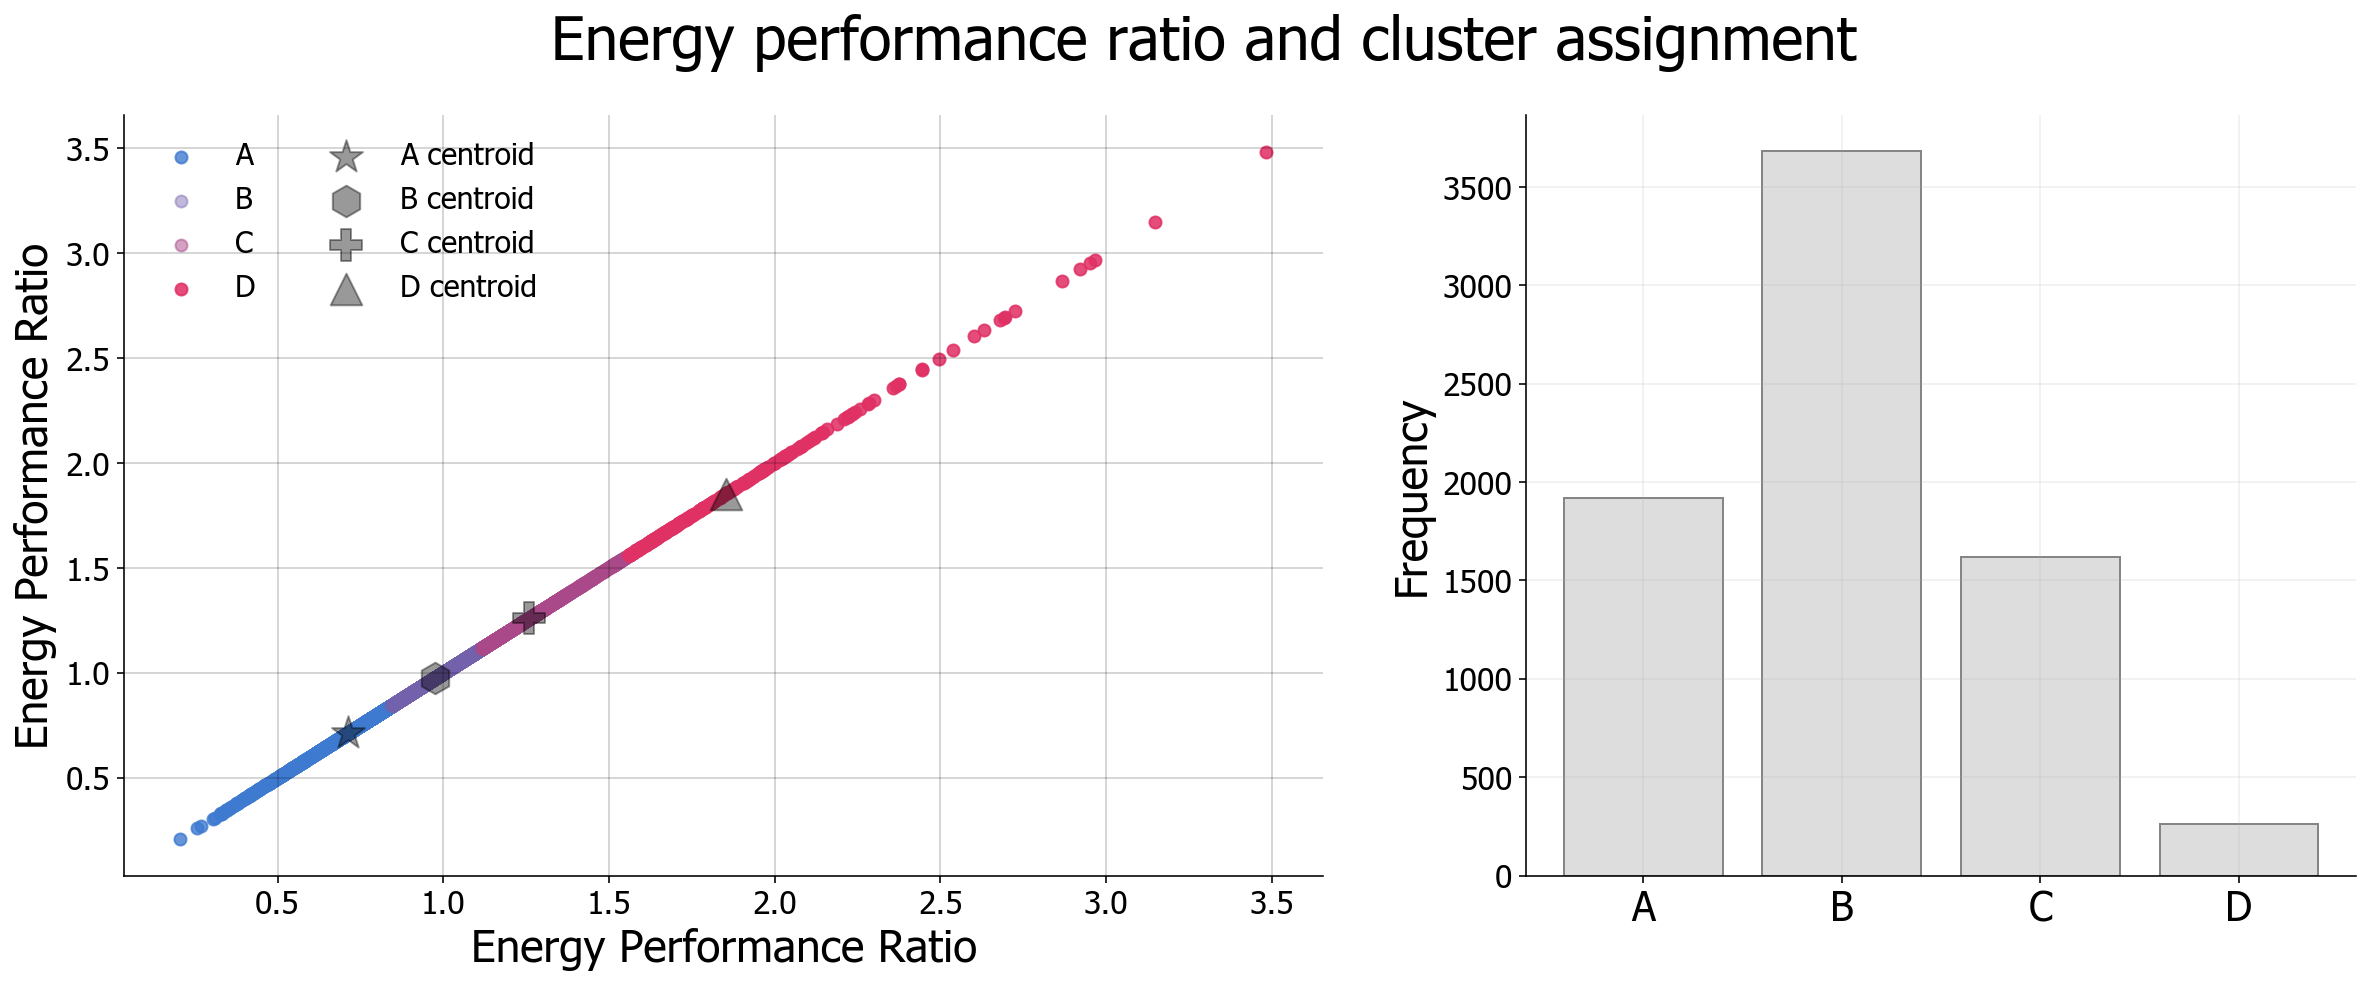

In [64]:
plt.figure(figsize=(20,7))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.6, 1.8]) 

plt.suptitle('Energy performance ratio and cluster assignment', size=30)
plt.subplot(gs[0])
dictPlot = dict(zip(bep['grade'].values, bep['label'].values))
size = 250

cmap = red_blue

plt.scatter(dfEr.error[dfEr.label==dictPlot.get('A')], 
            dfEr.error[dfEr.label==dictPlot.get('A')], c=bepCol[0], label='A')
plt.scatter(dfEr.error[dfEr.label==dictPlot.get('B')], 
            dfEr.error[dfEr.label==dictPlot.get('B')], c=bepCol[1], label='B')
plt.scatter(dfEr.error[dfEr.label==dictPlot.get('C')], 
            dfEr.error[dfEr.label==dictPlot.get('C')], c=bepCol[2], label='C')
plt.scatter(dfEr.error[dfEr.label==dictPlot.get('D')], 
            dfEr.error[dfEr.label==dictPlot.get('D')], c=bepCol[3], label='D')
plt.scatter(centroids[dictPlot.get('A')], 
            centroids[dictPlot.get('A')], color='black', alpha=0.4, marker='*', s=300, label='A centroid')
plt.scatter(centroids[dictPlot.get('B')], 
            centroids[dictPlot.get('B')], color='black', alpha=0.4, marker='h', s=size, label='B centroid')
plt.scatter(centroids[dictPlot.get('C')], 
            centroids[dictPlot.get('C')], color='black', alpha=0.4, marker='P', s=size, label='C centroid')
plt.scatter(centroids[dictPlot.get('D')], 
            centroids[dictPlot.get('D')], color='black', alpha=0.4, marker='^', s=size, label='D centroid')
plt.xlabel('Energy Performance Ratio', size=22)
plt.ylabel('Energy Performance Ratio', size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=15, loc='best', ncol=2)
plt.grid(True,color='k', alpha=0.2)
plt.subplot(gs[1])
plt.bar(range(0,4), bep.counts, color='gainsboro', edgecolor='gray', alpha=0.95)
plt.ylabel('Frequency', size=22)
plt.xticks(range(0,4), ['A', 'B', 'C', 'D'], size=20)
plt.yticks(size=16)
plt.grid(True, alpha=0.2)
plt.show()

### Sankey diagram

In [65]:
dfSankey = pd.read_csv(r'../data/green_scores.csv', usecols=['ESS', 'BEP_Score']).dropna()
dfSankey['value'] = 1
dfSankey['binESS'] = pd.cut(dfSankey['ESS'], np.array([0, 19, 49, 89, 100]), labels=['0-19', '20-49', '50-89', '90+'])
dfSankey.groupby(['binESS', 'BEP_Score'])['value'].count()

binESS  BEP_Score
0-19    A               2
        B             167
        C             608
        D             215
20-49   A              48
        B             788
        C             631
        D               6
50-89   A             747
        B            2081
        C             168
        D               6
90+     A             897
        B             191
        C              10
Name: value, dtype: int64

In [66]:
matchedScores = (dfSankey.groupby(['binESS', 'BEP_Score'])['value'].count()['0-19']['D'] + \
dfSankey.groupby(['binESS', 'BEP_Score'])['value'].count()['20-49']['C'] + \
dfSankey.groupby(['binESS', 'BEP_Score'])['value'].count()['50-89']['B'] + \
dfSankey.groupby(['binESS', 'BEP_Score'])['value'].count()['90+']['A'])/float(len(dfSankey))

print "Diverging scores (%):", round(1-matchedScores,2)

Diverging scores (%): 0.42


In [69]:
plot_df = pd.read_csv('../data/sankey_plot_data.csv')
plot_df['Value'] = dfSankey.groupby(['binESS', 'BEP_Score'])['value'].count().values

data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  plot_df['Node, Label'].dropna(axis=0, how='any'),
      color = plot_df['Color']
    ),
    link = dict(
      source = plot_df['Source'].dropna(axis=0, how='any'),
      target = plot_df['Target'].dropna(axis=0, how='any'),
      value = plot_df['Value'].dropna(axis=0, how='any'),
      color = plot_df['Link Color'].dropna(axis=0, how='any'),
  )
)

layout =  dict(
    title = "Interaction between EnergyStar scores and GREEN grades",
    height = 772,
    width = 950,
    font = dict(
      size = 20
    ),    
)

fig = dict(data=[data_trace], layout=layout)

offline.plot(fig, validate=False)

'file://G:\\My Drive\\PythonProjects\\Research\\BEP score\\scripts\\temp-plot.html'

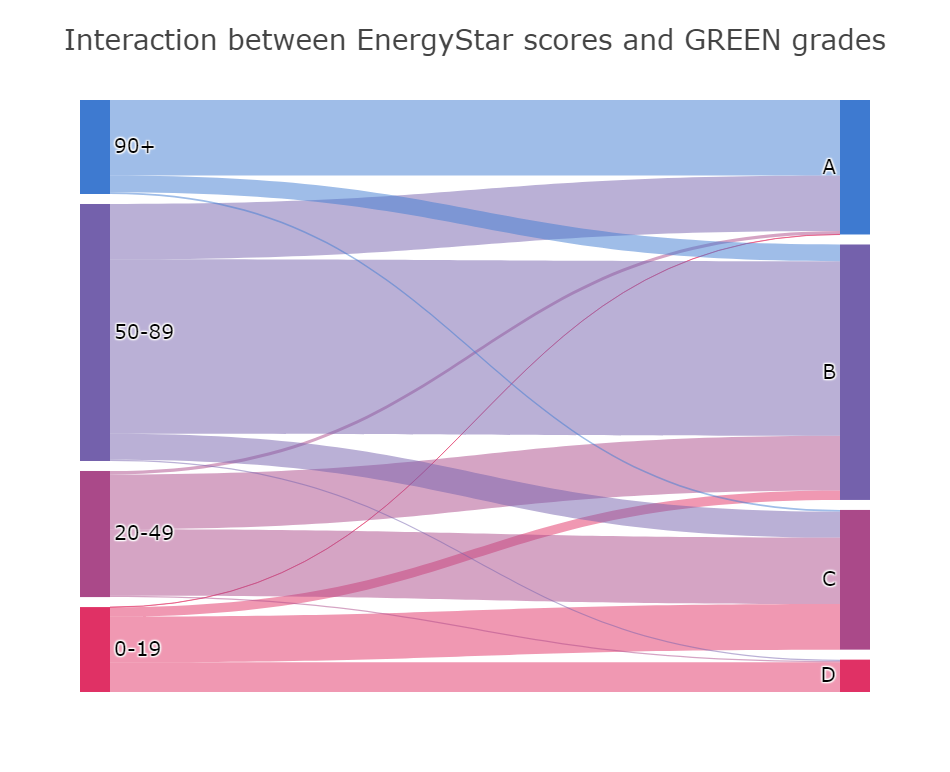

In [78]:
Image("../data/sankeyGREEN.png")

#### On the left node I plot the EnergyStar bin grading scheme proposed by NYC and on the right our proposed GREEN grading. There are quite a lot of interactions between the two grading schemes (more than 40% of buildings are assigned in different class), mostly in the average performing properties. 

## Descriptives statistics

In [70]:
desc = df[['Year', 'GFA', 'BuiltFAR', 'NumFloors', 'Electricity_primary', 'Units_dens', 'BldgValue_sqrft', 'non_main_type_%',
           'Multifamily Housing - Number of Bedrooms', 'Inside', 'Bedrooms_dens', 'Num_Units',
           'WN_Source_EUI', 'BEP_Score', 'ESS']]

In [71]:
# Descriptives for full sample
desc.median()

Year                                         1941.000000
GFA                                         85550.000000
BuiltFAR                                        4.460000
NumFloors                                       6.000000
Electricity_primary                             0.000000
Units_dens                                      0.934154
BldgValue_sqrft                                28.898743
non_main_type_%                               100.000000
Multifamily Housing - Number of Bedrooms      113.000000
Inside                                          0.000000
Bedrooms_dens                                   1.376871
Num_Units                                      78.000000
WN_Source_EUI                                 124.200000
ESS                                            62.000000
dtype: float64

In [72]:
# Descriptives for each grade
desc.groupby('BEP_Score').median().T

BEP_Score,A,B,C,D
Year,1940.000000,1941.000000,1941.000000,1940.000000
GFA,86333.000000,84630.000000,86040.500000,86439.000000
BuiltFAR,4.520000,4.420000,4.465000,4.625000
NumFloors,6.000000,6.000000,6.000000,6.000000
Electricity_primary,0.000000,0.000000,0.000000,0.000000
Units_dens,0.934179,0.929870,0.944817,0.931656
BldgValue_sqrft,30.285666,27.716763,29.170153,39.425654
non_main_type_%,100.000000,100.000000,100.000000,100.000000
Multifamily Housing - Number of Bedrooms,114.000000,113.000000,114.000000,109.775000
Inside,0.000000,0.000000,0.000000,0.000000


#### Feature medians are in general consistent across different GREEN grades. This shows that the model is not biased towards buildings with particular physical, qualitative, or operational characteristics.